In [2]:
import setuptools
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

load_dotenv()
SPARK_HOST = os.getenv('SPARK_HOST')
SPARK_APP_NAME = os.getenv('SPARK_APP_NAME')

spark = SparkSession.builder.remote(SPARK_HOST).appName(SPARK_APP_NAME).getOrCreate()

ROOT = os.getenv('WORKING_DIR')

In [17]:
traficom = spark.read.parquet(ROOT + 'data/tax_trafi_merged_data')
imputed_prices = spark.read.parquet(ROOT + 'data/knn_imputed_prices')
df = traficom.join(imputed_prices, on='index')

df = df.withColumn('year_of_first_registration', F.year(F.col('date_of_first_registration')))

df2 = df.select('make_plaintext', 'manufac_trade_name', 'model', 'date_of_first_registration', 'year_of_first_registration', 'n_doors', 'mass', 'drive_power', 'engine_capacity', 'max_net_engine_power_kw', 'driving_power_euro_vi', 'pred_price', 'imputed_price')
df2.persist()

DataFrame[make_plaintext: string, manufac_trade_name: string, model: string, date_of_first_registration: date, year_of_first_registration: int, n_doors: int, mass: int, drive_power: string, engine_capacity: int, max_net_engine_power_kw: double, driving_power_euro_vi: string, pred_price: double, imputed_price: double]

In [18]:
df2.show(5)
df2.count()

+--------------+------------------+--------------------+--------------------------+--------------------------+-------+----+-----------+---------------+-----------------------+---------------------+----------+------------------+
|make_plaintext|manufac_trade_name|               model|date_of_first_registration|year_of_first_registration|n_doors|mass|drive_power|engine_capacity|max_net_engine_power_kw|driving_power_euro_vi|pred_price|     imputed_price|
+--------------+------------------+--------------------+--------------------------+--------------------------+-------+----+-----------+---------------+-----------------------+---------------------+----------+------------------+
|        Toyota|     COROLLA VERSO|5D COROLLA VERSO ...|                2011-09-16|                      2011|      4|1570|         02|           2230|                  100.0|                   02|      NULL| 46330.58763056997|
|          Audi|                A6|4D A6 SEDAN QUATT...|                2015-04-11|     

np.int64(1447903)

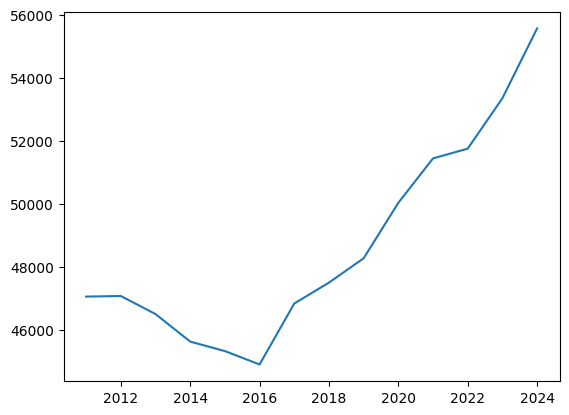

In [22]:


data = np.array(df2.groupBy('year_of_first_registration').mean('imputed_price').orderBy('year_of_first_registration').collect())



plt.plot(data[:, 0], data[:, 1])

In [23]:
df = spark.read.parquet(ROOT + 'data/preprocessed_regression_data')

In [27]:
df = df.filter((F.col('registration_year') >= 2015) & (F.col('registration_year') <= 2022))
df = df.withColumn('population', F.col('population').cast('int'))
df.printSchema()
#df.show(5)
electric = np.array(df.filter(F.col('electric') == 1).groupBy('registration_year').mean('price', 'vtax', 'fuelCost', 'cents_kWh', 'hh_med_income', 'population').collect())
gasoline = np.array(df.filter(F.col('electric') == 0).groupBy('registration_year').mean('price', 'vtax', 'fuelCost', 'cents_kWh', 'hh_med_income', 'population').collect())
grouped = df.groupBy('registration_year').mean('price', 'vtax', 'fuelCost', 'cents_kWh', 'hh_med_income', 'population')
grouped.show(5)
grouped_year = np.array(grouped.collect())



root
 |-- municipality: string (nullable = true)
 |-- registration_year: integer (nullable = true)
 |-- index: long (nullable = true)
 |-- n_doors: integer (nullable = true)
 |-- n_seats: integer (nullable = true)
 |-- body_type: string (nullable = true)
 |-- region: string (nullable = true)
 |-- vtax: double (nullable = true)
 |-- price: double (nullable = true)
 |-- electric: integer (nullable = true)
 |-- fuelCost: double (nullable = true)
 |-- cents_kWh: double (nullable = true)
 |-- hh_med_income: integer (nullable = true)
 |-- population: integer (nullable = true)

+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|registration_year|        avg(price)|         avg(vtax)|     avg(fuelCost)|    avg(cents_kWh)|avg(hh_med_income)|   avg(population)|
+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|             2019|4

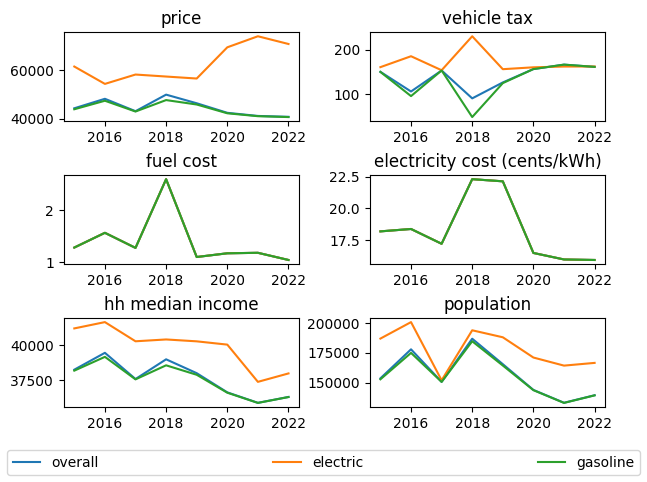

In [48]:
len(range(2015, 2023))

fig, axes = plt.subplots(3, 2)
fig.tight_layout(pad=2)
titles=['price', 'vehicle tax', 'fuel cost', 'electricity cost (cents/kWh)', 'hh median income', 'population']

for i in range(6):
    ax = axes.flatten()[i]
    ax.title.set_text(titles[i])
    ax.plot(range(2015, 2023), grouped_year[:, i + 1], label='overall')
    ax.plot(range(2015, 2023), electric[:, i + 1], label='electric')
    ax.plot(range(2015, 2023), gasoline[:, i + 1], label='gasoline')

fig.legend(('overall', 'electric', 'gasoline'), mode='expand', ncol=3, loc='lower center')
fig.subplots_adjust(bottom=0.15)

In [55]:
import json

with open(ROOT + 'data/ocm_data.json', 'r') as f:
    data = f.read()

ocm_data = pd.json_normalize(json.loads(data))
ocm_data = spark.createDataFrame(ocm_data['DateCreated'])
ocm_data = ocm_data.withColumn('year', F.year(F.col('_1'))).select('year')

rng = range(2015, 2023)
charging_stations = np.zeros(len(rng))
evs = np.zeros(len(rng))

for i, y in enumerate(rng):
    charging_stations[i] = ocm_data.filter(F.col('year') <= y).count()
    evs[i] = df.filter((F.col('electric') == 1) & (F.col('registration_year') <= y)).count()
    
    

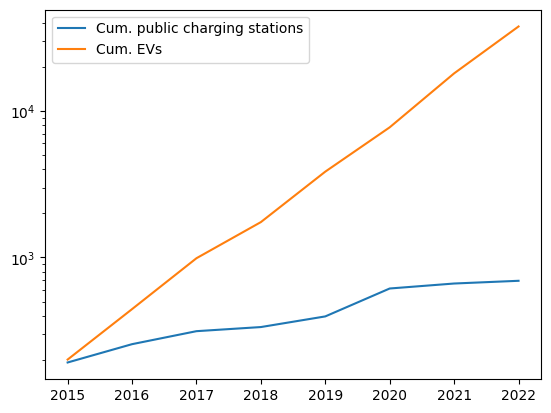

In [59]:
plt.plot(rng, charging_stations, label='Cum. public charging stations')
plt.plot(rng, evs, label='Cum. EVs')
plt.yscale("log")
plt.legend()